In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
import pandas as pd
import numpy as np
import re

# Training Data Preparation

## CIFAR-10 training from scratch

### Data Processing

In [0]:
path = untar_data(URLs.CIFAR)

In [4]:
path_lr=path/'train'
path.ls()

[PosixPath('/root/.fastai/data/cifar10/train'),
 PosixPath('/root/.fastai/data/cifar10/labels.txt'),
 PosixPath('/root/.fastai/data/cifar10/test')]

In [0]:
bs,size=128,32

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=42)

In [8]:
labels= pd.read_csv(path/'labels.txt')
labels

,airplane
0,automobile
1,bird
2,cat
3,deer
4,dog
5,frog
6,horse
7,ship
8,truck


In [0]:
data = (ImageList.from_folder(path).split_by_rand_pct(0.2, seed=42)
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))

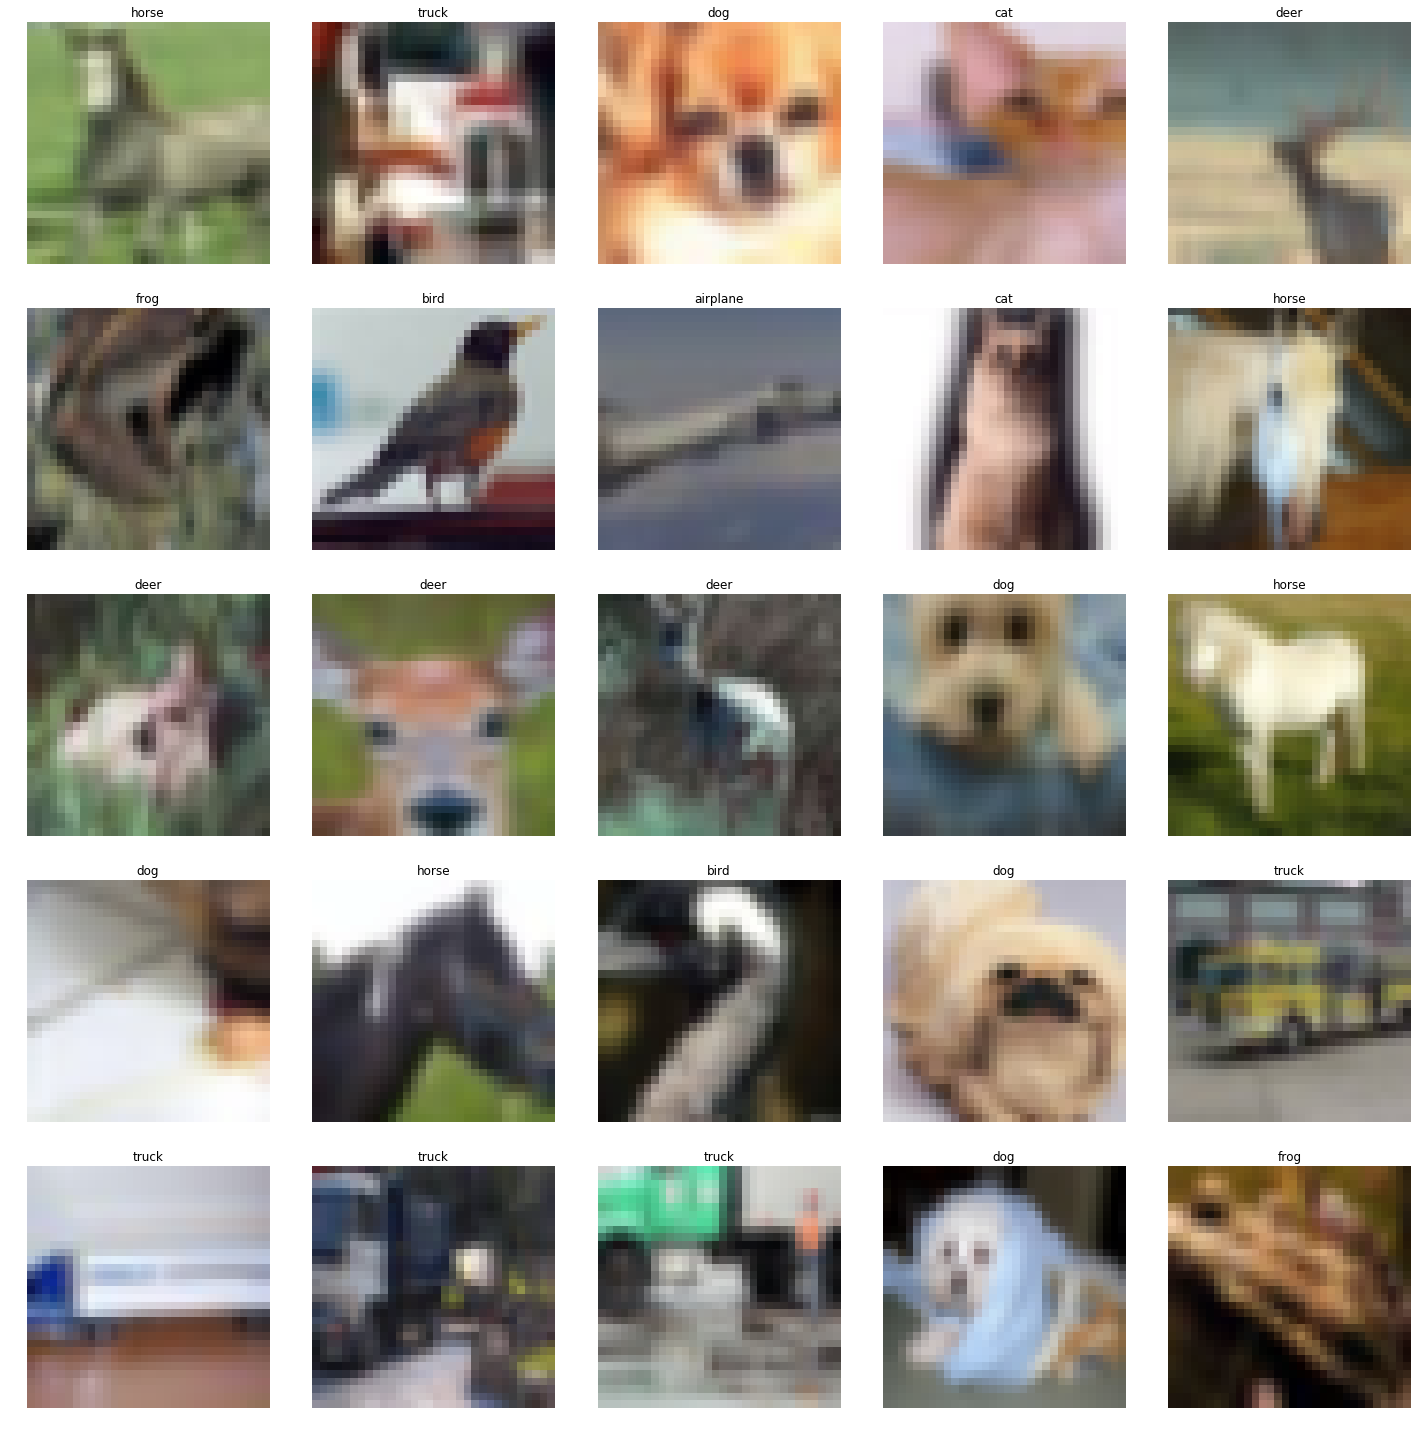

In [10]:
data.show_batch()

# Reference Oct Conv Implementation

I obtained an implementation of OctConv for various resnet models from here: <https://github.com/kk1694/octaveconv-pytorch>

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

__all__ = ['OctResNet', 'oct_resnet18', 'oct_resnet34', 'oct_resnet50', 
           'oct_resnet101', 'oct_resnet152']

class TensorTuple():
    '''Stores high and low frequency tensors.'''    
    def __init__(self, hf, lf):
        self.hf, self.lf = hf, lf
        self.shape = (self.hf.shape, self.lf.shape)
        
    def __repr__(self):
        return 'tensor_tuple: '+self.hf.__repr__() + self.lf.__repr__()
        
    def __add__(self, other):
        return TensorTuple(self.hf+other.hf, self.lf+other.lf)
    
def tupify(layer):
    
    '''Turns a layer (say relu of maxpool) into one that operates on TensorTuple'''
    
    if hasattr(layer, 'tupified'):
        if layer.tupified: return layer
    
    class Tuplefied(nn.Module):
        tupified=True
        def __init__(self, *args, **kwargs):        
            super().__init__()
            self.inst1, self.inst2 = layer(*args, **kwargs), layer(*args, **kwargs)
        def forward(self, x):
            return TensorTuple(self.inst1(x.hf), self.inst2(x.lf))        
    return Tuplefied

def tupify_bn(layer, alpha):
    
    '''Turns a batch norm layer into one that operates on Tensortuple'''
    
    if hasattr(layer, 'tupified'):
        if layer.tupified: return layer
    
    class Tuplefied(nn.Module):
        tupified=True
        def __init__(self, num_features, *args, **kwargs):        
            super().__init__()
            num_lf = int(alpha*num_features)
            num_hf = num_features-num_lf
            self.inst1, self.inst2 = layer(num_hf, *args, **kwargs), layer(num_lf, *args, **kwargs)
        def forward(self, x):
            return TensorTuple(self.inst1(x.hf), self.inst2(x.lf))        
    return Tuplefied

class OctConv(nn.Module):
    
    '''Main layer replacing nn.Conv2d'''
    
    def __init__(self, in_channels, out_channels, alpha, **kwargs):
        
        super(OctConv, self).__init__()        
        if not isinstance(alpha, (tuple,list)):
            alpha = (alpha, alpha)
        assert alpha[0] >= 0 and alpha[0] < 1 and alpha[1] >= 0 and alpha[1] < 1
        
        self.low_in, self.low_out = int(alpha[0] * in_channels), int(alpha[1] * out_channels)
        self.high_in, self.high_out = in_channels-self.low_in, out_channels-self.low_out
        
        if self.low_in != 0:
            self.L2H = nn.Conv2d(self.low_in, self.high_out, **kwargs)
            nn.init.kaiming_normal_(self.L2H.weight, mode='fan_out', nonlinearity='relu')
            
            if self.low_out != 0:
                self.L2L = nn.Conv2d(self.low_in, self.low_out, **kwargs) 
                nn.init.kaiming_normal_(self.L2L.weight, mode='fan_out', nonlinearity='relu')
            
        if self.low_out != 0:
            self.H2L = nn.Conv2d(self.high_in, self.low_out, **kwargs)
            nn.init.kaiming_normal_(self.H2L.weight, mode='fan_out', nonlinearity='relu')
            
        self.H2H = nn.Conv2d(self.high_in, self.high_out, **kwargs)
        nn.init.kaiming_normal_(self.H2H.weight, mode='fan_out', nonlinearity='relu')
        
        self.upsample = partial(F.interpolate, mode='nearest')
        self.avg_pool = partial(F.avg_pool2d, kernel_size=2)

    def forward(self, x):
        
        if self.low_in == 0 and self.low_out == 0:
            return self.H2H(x)  # Regular convolution
        elif self.low_in == 0 and self.low_out > 0:
            return TensorTuple(self.H2H(x), self.H2L(self.avg_pool(x)))
        elif self.low_in > 0 and self.low_out == 0:
            hf, lf = x.hf, x.lf
            hh = self.H2H(hf)
            return hh + self.upsample(self.L2H(lf), size=hh.shape[2:])
        else:
            hf, lf = x.hf, x.lf
            hh = self.H2H(hf); ll = self.L2L(lf)
            if hf.shape[2]%2 ==0 and hf.shape[3]%2==0:
                l_out = ll + self.H2L(self.avg_pool(hf))
            else:
                l_out = ll + self.H2L(F.adaptive_avg_pool2d(hf, ll.shape[2:]))
            return TensorTuple(hh + self.upsample(self.L2H(lf), size=hh.shape[2:]), l_out)    
        
def conv3x3(in_planes, out_planes, alpha, stride=1, groups=1, oct_layer=True):
    """3x3 convolution with padding"""
    if oct_layer:
        return OctConv(in_planes, out_planes, alpha, kernel_size=3, stride=stride,
                       padding=1, groups=groups, bias=False)
    else:
        return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                         padding=1, groups=groups, bias=False)

def conv1x1(in_planes, out_planes, alpha, stride=1, oct_layer=True):
    """1x1 convolution"""
    if oct_layer:
        return OctConv(in_planes, out_planes, alpha, kernel_size=1, stride=stride, bias=False)
    else:
        return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class OctBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, alpha, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None, last_block=False):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
            
        relu_layer = nn.ReLU if last_block else tupify(nn.ReLU)
        norm_layer = norm_layer if last_block else tupify_bn(norm_layer, alpha)
        alpha = (alpha, 0) if last_block else alpha
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, alpha, stride)
        self.bn1 = norm_layer(planes)
        self.relu = relu_layer(inplace=True)
        self.conv2 = conv3x3(planes, planes, alpha, oct_layer=not last_block)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
            
        if isinstance(out, TensorTuple):    
            out += identity
        else:
            pass
            # This is the case of the last conv layer
            # I could interpolate identity.lf to high frequency,
            # but I think it might be best to keep the last block
            # without the skip connection. Will add the option later.        
        
        out = self.relu(out)

        return out

class OctBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, alpha, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None, last_block=False):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        
        relu_layer = nn.ReLU if last_block else tupify(nn.ReLU)
        norm_layer = norm_layer if last_block else tupify_bn(norm_layer, alpha)
        alpha = (alpha, 0) if last_block else alpha
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width, alpha)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, alpha, stride, groups, oct_layer=not last_block)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion, alpha, oct_layer=not last_block)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = relu_layer(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if isinstance(out, TensorTuple):    
            out += identity
        else:
            pass
            # This is the case of the last conv layer
            # I could interpolate identity.lf to high frequency,
            # but I think it might be best to keep the last block
            # without the skip connection. Will add the option later.        
            
        out = self.relu(out)

        return out


class OctResNet(nn.Module):

    def __init__(self, block, layers, alpha, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
            
        self.alpha = alpha
        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = OctConv(3, self.inplanes, alpha = (0, alpha), kernel_size=7, stride=2, padding=3,
                               bias=False)        
        self.bn1 = tupify_bn(norm_layer, alpha)(self.inplanes)
        self.relu = tupify(nn.ReLU)(inplace=True)
        self.maxpool = tupify(nn.MaxPool2d)(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer,last_block=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None, last_block=False):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, self.alpha, stride),
                tupify_bn(norm_layer, self.alpha)(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.alpha, stride, downsample, self.groups,
                            self.base_width, norm_layer))
        self.inplanes = planes * block.expansion
        for k in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.alpha, groups=self.groups,
                                base_width=self.base_width, norm_layer=norm_layer,
                                last_block=last_block and k == (blocks-1)))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def oct_resnet18(alpha, pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(OctBasicBlock, [2, 2, 2, 2], alpha, **kwargs)
    if pretrained:
        raise NotImplementedError
    return model


def oct_resnet34(alpha, pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(OctBasicBlock, [3, 4, 6, 3], alpha,  **kwargs)
    if pretrained:
        raise NotImplementedError
    return model


def oct_resnet50(alpha, pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(OctBottleneck, [3, 4, 6, 3], alpha, **kwargs)
    if pretrained:
        raise NotImplementedError
    return model


def oct_resnet101(alpha, pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(OctBottleneck, [3, 4, 23, 3], alpha, **kwargs)
    if pretrained:
        raise NotImplementedError
    return model


def oct_resnet152(alpha, pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(OctBottleneck, [3, 8, 36, 3], alpha, **kwargs)
    if pretrained:
        raise NotImplementedError
    return model


# Training with Oct-Resnet-50

In [0]:
model = oct_resnet50(0.25, num_classes=10).cuda()

In [0]:
learn = Learner(data, model, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


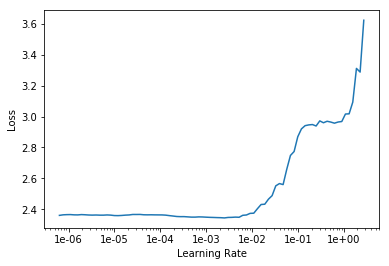

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
niters = 5
%timeit
learn.fit_one_cycle(niters,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.961316,2.024244,0.253500,03:46
1,1.812552,1.985238,0.316750,03:46
2,1.644868,1.808893,0.349583,03:45
3,1.413407,1.610559,0.431083,03:46
4,1.303006,1.554790,0.447167,03:45


# Reference ResNet Implementation

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model


def resnext50_32x4d(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], groups=32, width_per_group=4, **kwargs)
    # if pretrained:
    #     model.load_state_dict(model_zoo.load_url(model_urls['resnext50_32x4d']))
    return model


def resnext101_32x8d(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 23, 3], groups=32, width_per_group=8, **kwargs)
    # if pretrained:
    #     model.load_state_dict(model_zoo.load_url(model_urls['resnext101_32x8d']))
    return model

# Training with Resnet-50

In [0]:
model1 = resnet50(num_classes=10).cuda()

In [0]:
learn1 = Learner(data,model1, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


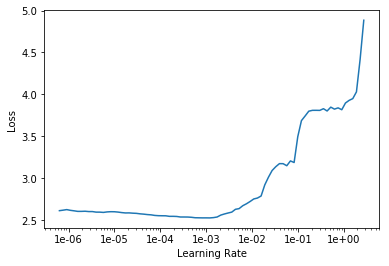

In [19]:
learn1.lr_find()
learn1.recorder.plot()

In [20]:
%timeit
learn1.fit_one_cycle(niters,1e-3 )

epoch,train_loss,valid_loss,accuracy,time
0,2.048135,2.014067,0.238000,00:52
1,1.811107,1.900499,0.344833,00:52
2,1.594099,1.771427,0.392083,00:53
3,1.335517,1.577770,0.448917,00:52
4,1.175825,1.540693,0.468667,00:52
